In [1]:
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import ListedColormap

import torch
from torch.utils.data import DataLoader

from patchseg.dataset import CocoPatchDataset

In [2]:
# Configuration (ViT-B/16 setup).
image_width = 224
patch_size = 16
image_mean = (0, 0, 0)
image_std = (1, 1, 1)
label_reduction = "majority"
batch_size = 8
num_workers = 0

In [3]:
# Prepare dataset.
val_dataset = CocoPatchDataset(
    image_width=image_width,
    patch_size=patch_size,
    split="val",
    image_mean=image_mean,
    image_std=image_std,
    label_reduction=label_reduction,
    dataset_path="../coco"
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    pin_memory=True,
    num_workers=num_workers,
    shuffle=True,
    drop_last=False,
)

# Plot images and patch labels

In [4]:
# Prepare batch of images and annotations.
images, annotations = next(iter(val_loader))

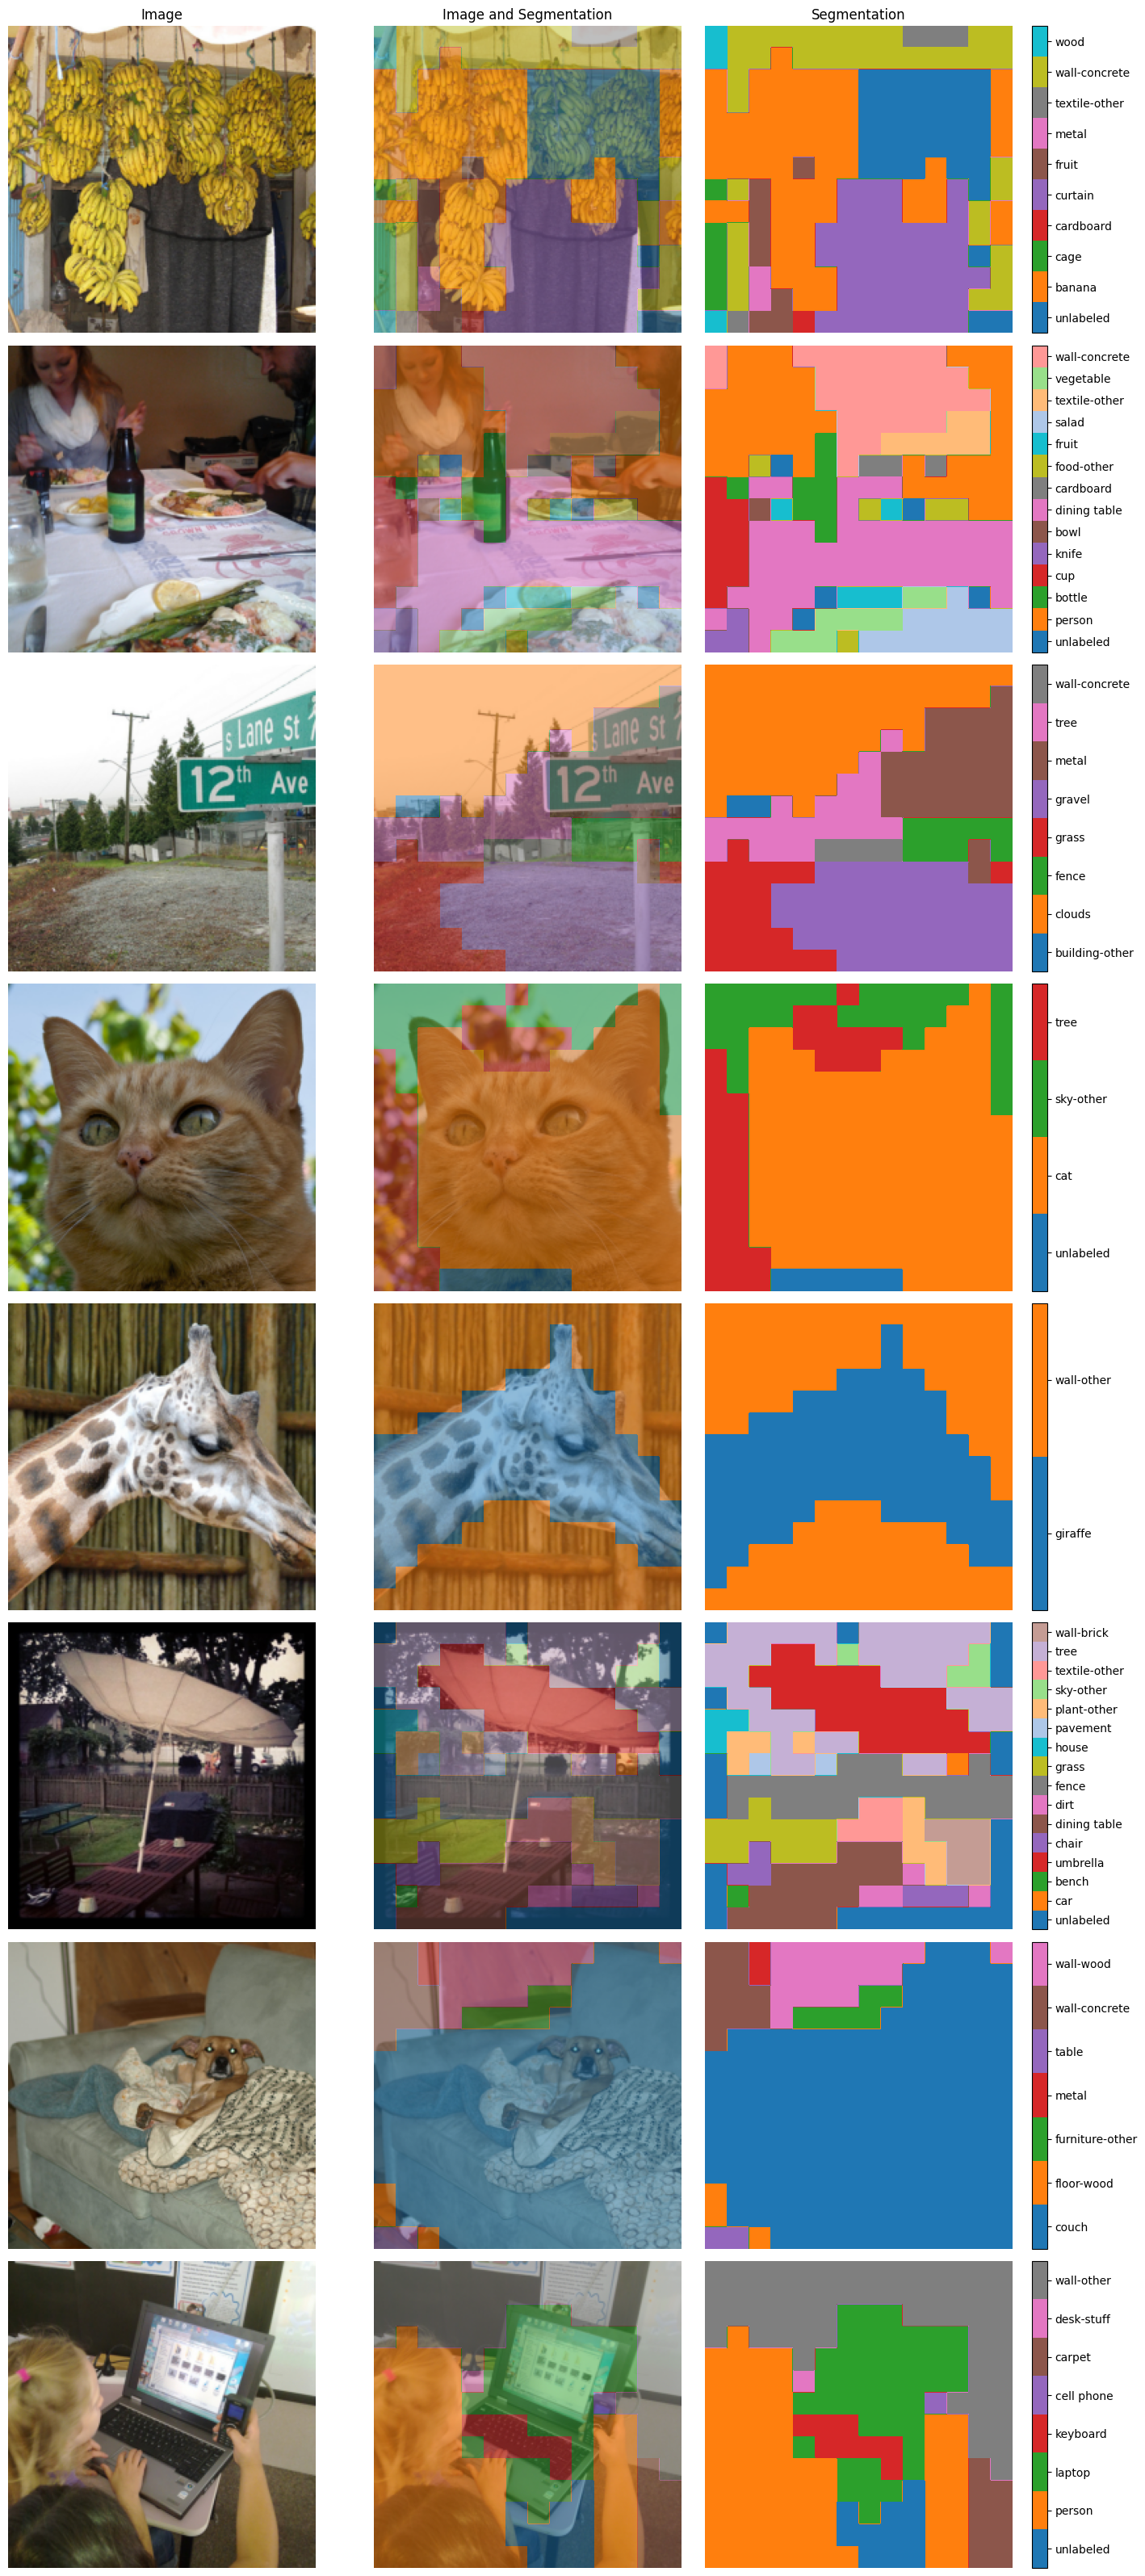

In [5]:
# Plot images and annotations.
fig, axarr = plt.subplots(batch_size, 3, figsize=(15, batch_size * 4))

for i, (image, annotation) in enumerate(zip(images, annotations)):
    # Image only.
    display_image = image.permute(1, 2, 0)
    axarr[i, 0].imshow(display_image)
    axarr[i, 0].axis("off")

    # Image and annotation.
    axarr[i, 1].imshow(display_image)
    axarr[i, 1].axis("off")

    display_annotation = torch.zeros_like(annotation)
    unique_classes = torch.unique(annotation.flatten())
    for j, class_index in enumerate(unique_classes):
        display_annotation[annotation == class_index] = j
    display_annotation = torch.nn.functional.interpolate(display_annotation.unsqueeze(0).unsqueeze(0).float(), scale_factor=patch_size, mode="nearest").squeeze().long()
    cmap = colormaps.get_cmap("tab20")
    cmap = ListedColormap([cmap.colors[(2 * i + i // 10) % 20] for i in range(len(unique_classes))])
    axarr[i, 1].imshow(display_annotation, cmap=cmap, alpha=0.5)

    # Annotation only.
    imshow = axarr[i, 2].imshow(display_annotation, cmap=cmap, alpha=1.0)
    axarr[i, 2].axis("off")
    cbar = plt.colorbar(imshow, ax=axarr[i, 2])
    cbar.set_ticks((0.5 + torch.arange(len(unique_classes))) * (len(unique_classes) - 1) / len(unique_classes))
    cbar.set_ticklabels([val_dataset.index_to_class[class_index.item()] for class_index in unique_classes])

    # Set subplot labels.
    if i == 0:
        axarr[i, 0].set_title("Image")
        axarr[i, 1].set_title("Image and Segmentation")
        axarr[i, 2].set_title("Segmentation")

plt.tight_layout()
plt.show()

# Plot class distribution

In [6]:
# Setup for counting.
class_counts = torch.zeros(val_dataset.num_classes)
class_image_counts = torch.zeros(val_dataset.num_classes)
patch_counts = 0
image_counts = 0

In [7]:
# Count by iterating over the dataset.
for images, annotations in tqdm(val_loader):
    for annotation in annotations:
        for index in annotation.flatten():
            class_counts[index] += 1
        unique_classes = torch.unique(annotation.flatten())
        class_image_counts[unique_classes] += 1
    patch_counts += annotations.numel()
    image_counts += len(images)

  0%|          | 0/625 [00:00<?, ?it/s]

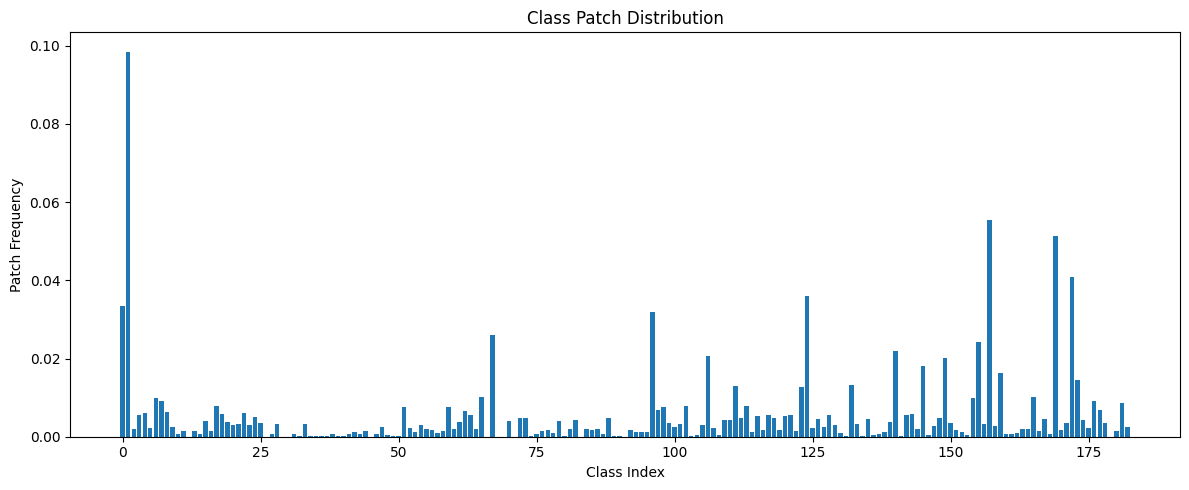

In [8]:
# Plot the class distribution by patches.
plt.figure(figsize=(12, 5))
plt.bar(range(val_dataset.num_classes), class_counts / patch_counts)
plt.xlabel("Class Index")
plt.ylabel("Patch Frequency")
plt.title("Class Patch Distribution")
plt.tight_layout()
plt.show()

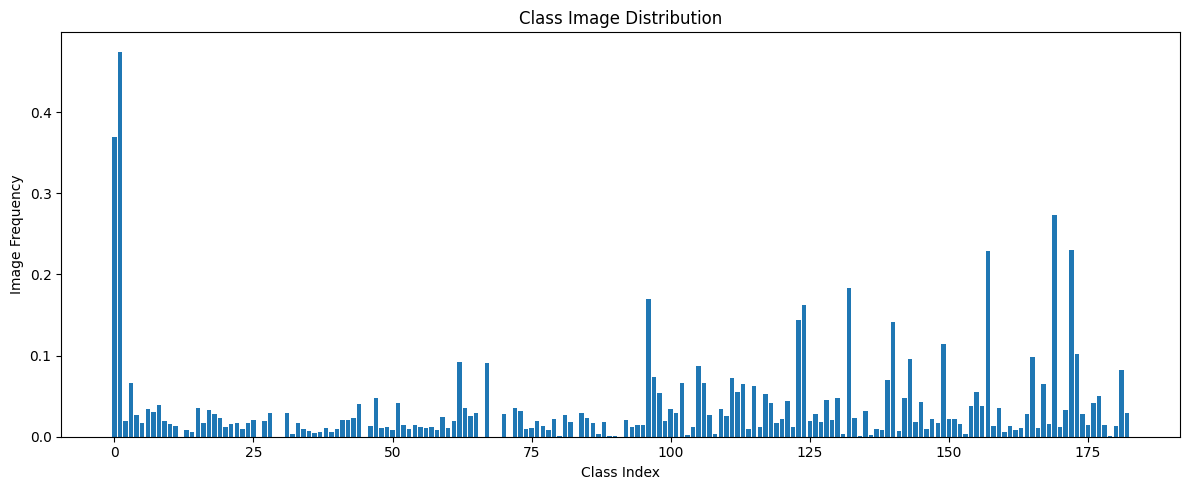

In [9]:
# Plot the class distribution by images.
plt.figure(figsize=(12, 5))
plt.bar(range(val_dataset.num_classes), class_image_counts / image_counts)
plt.xlabel("Class Index")
plt.ylabel("Image Frequency")
plt.title("Class Image Distribution")
plt.tight_layout()
plt.show()

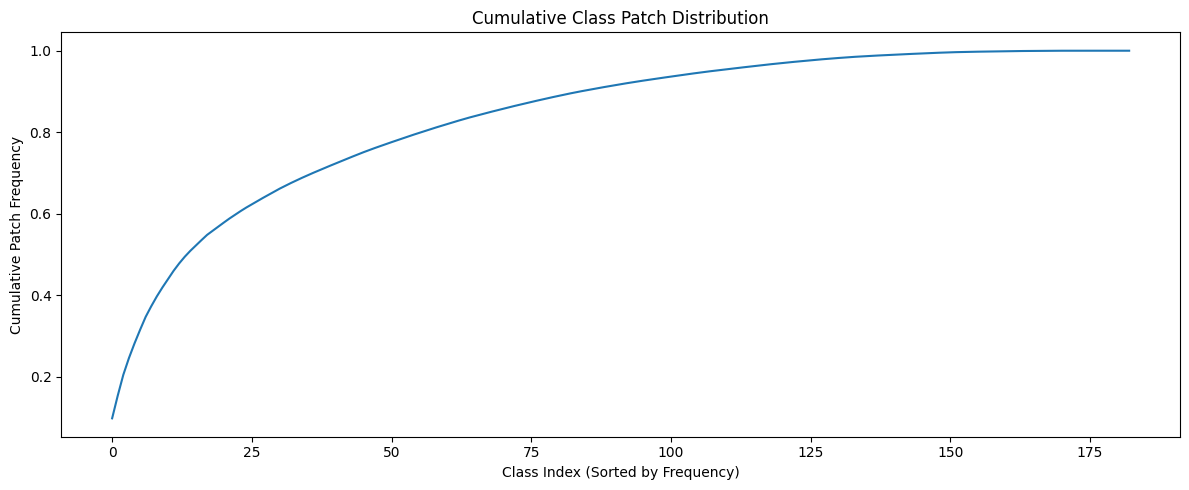

In [10]:
# Plot the cumulative class distribution.
plt.figure(figsize=(12, 5))
cumulative_frequency = torch.cumsum(torch.sort(class_counts, descending=True).values / patch_counts, dim=0)
plt.plot(range(val_dataset.num_classes), cumulative_frequency)
plt.xlabel("Class Index (Sorted by Frequency)")
plt.ylabel("Cumulative Patch Frequency")
plt.title("Cumulative Class Patch Distribution")
plt.tight_layout()
plt.show()